In [1]:
# install machine gnostics
# recommended to run in a new virtual environment

# !pip install machinegnostics #<-- Uncomment this line to install the package

# Small data (with noise) and regression

### **Overview**
The **Machine Gnostics Polynomial Regressor** is a robust modeling tool that abandons the Gaussian assumptions of classical Ordinary Least Squares (OLS). Instead of minimizing squared Euclidean errors, this model operates within a **Machine Gnostics [Riemannian geometric] framework**, treating data as events within a curved space of uncertainty.

By leveraging the **Ideal Gnostic Cycle (IGC)**, this regressor optimizes thermodynamic criteria—specifically maximizing **Information** and minimizing **Entropy**—rather than simple variance. This approach ensures that the model is naturally robust to outliers (outer robustness) or inliers (inner robustness), depending on the chosen criterion, without requiring manual trimming or subjective thresholding.

---

### **Theoretical Background (Note for Users)**

For those familiar with the *Mathematical Gnostics* framework, this regressor implements the **Gnostic Weighted Least Squares (GWLS)** methodology. Key theoretical distinctions include:

*   **Thermodynamic Optimization:**
    Unlike statistical regression which minimizes variance (a mechanical concept), this model minimizes the **Residual Entropy** ($f_J - f_I$) or maximizes **Fidelity** ($f_E$) of the system. It seeks the path of maximum information yield rather than just the line of best fit.

*   **Riemannian Metric:**
    The model rejects the flat Euclidean space of standard statistics. It applies a **Riemannian metric** determined by the data itself. The local curvature of the space defines how errors are measured, automatically down-weighting data points that generate high uncertainty (entropy).

*   **Dynamic Weighting (Fidelity & Irrelevance):**
    Weights are not fixed. In every iteration of the solver, the model calculates the **Gnostic Fidelity** ($f$) and **Irrelevance** ($h$) of each data event.
    *   *Outlier Robustness:* High irrelevance ($h \to \pm 1$) results in low fidelity ($f \to 0$), effectively filtering out contaminated data dynamically.

*   **Regression in Probabilities:**
    To ensure scale invariance and handle diverse physical units, the model can operate on **Gnostic Probabilities** rather than raw values. This transforms all inputs to the dimensionless domain $(0,1)$ using the **Estimating Global Distribution Function (EGDF)**, allowing for a consistent evaluation of variable impact.

***


## Example 1: Simple Polynomial Regression

A basic example showing how to use the Polynomial Regressor with noisy data and outliers.

In [2]:
import numpy as np
from machinegnostics.models import PolynomialRegressor

# Generate data with outliers
np.random.seed(42)
X = np.linspace(0, 2, 10).reshape(-1, 1)
y = 2.0 * np.exp(1.8 * X.ravel()) + np.random.normal(0, 0.2, 10)
y[8:] += [80.0, -8.0]  # Add outliers

# Fit the model
model = PolynomialRegressor(degree=2)
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

print("Model fitted successfully!")
print(f"Coefficients: {model.coefficients}")
print(f"MSE: {np.mean((y_pred - y)**2):.4f}")

Model fitted successfully!
Coefficients: [ 2.64573373 -2.11707058 12.49262107]
MSE: 851.0057


### Basic Visualization

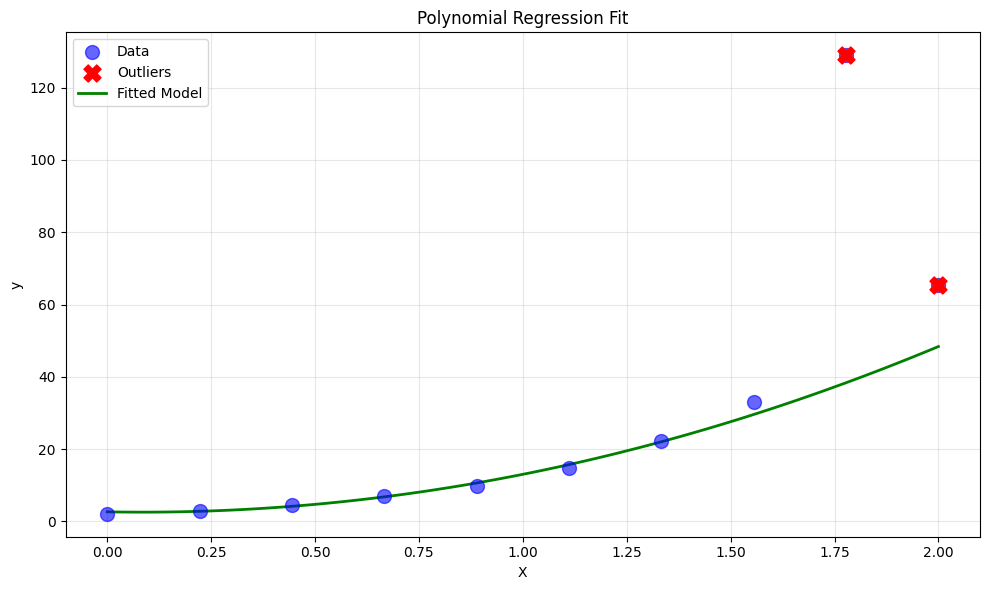

In [3]:
import matplotlib.pyplot as plt

# Generate smooth curve for visualization
X_test = np.linspace(0, 2, 100).reshape(-1, 1)
y_test = model.predict(X_test)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', s=100, label='Data', zorder=3, alpha=0.6)
plt.scatter(X[8:], y[8:], color='red', s=150, label='Outliers', zorder=4, marker='X')
plt.plot(X_test, y_test, 'g-', linewidth=2, label='Fitted Model')

plt.xlabel('X')
plt.ylabel('y')
plt.title('Polynomial Regression Fit')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Example 2: Understanding Gnostic Weights

This example shows how the model automatically identifies and down-weights outliers.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from machinegnostics.models import PolynomialRegressor

# Generate data with outliers
np.random.seed(42)
X = np.linspace(0, 2, 10).reshape(-1, 1)
y = 2.0 * np.exp(1.8 * X.ravel()) + np.random.normal(0, 0.2, 10)
y[8:] += [80.0, -8.0]  # Add outliers

# Fit model
model = PolynomialRegressor(degree=2, verbose=False, max_iter=200, early_stopping=True, tolerance=0.01)
model.fit(X, y)

# Access weights
weights = model.weights

print("Gnostic Weights (automatic down-weighting):")
print("-" * 50)
for i, w in enumerate(weights):
    status = "OUTLIER - Low Weight" if i >= 8 else "Normal"
    print(f"Point {i}: {w:.4f}  <- {status}")
    
print(f"\nMean weight: {np.mean(weights):.4f}")
print(f"Outlier weights: {weights[8]:.4f}, {weights[9]:.4f}")

Gnostic Weights (automatic down-weighting):
--------------------------------------------------
Point 0: 0.1462  <- Normal
Point 1: 0.1438  <- Normal
Point 2: 0.1312  <- Normal
Point 3: 0.1371  <- Normal
Point 4: 0.1520  <- Normal
Point 5: 0.1349  <- Normal
Point 6: 0.0942  <- Normal
Point 7: 0.0547  <- Normal
Point 8: 0.0000  <- OUTLIER - Low Weight
Point 9: 0.0058  <- OUTLIER - Low Weight

Mean weight: 0.1000
Outlier weights: 0.0000, 0.0058


### Visualize Model Fit with Weights

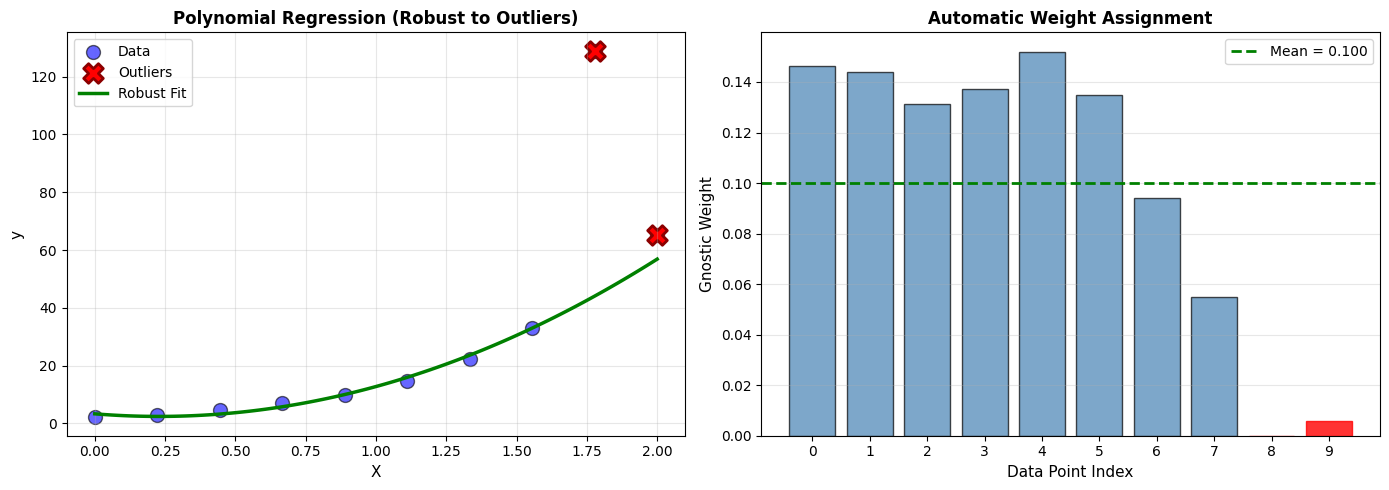


Key Insight: Outliers (points 8, 9) get LOW weights automatically
            This prevents them from distorting the model!


In [5]:
# Create comprehensive visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Fitted curve
X_test = np.linspace(0, 2, 100).reshape(-1, 1)
y_test = model.predict(X_test)

ax1.scatter(X, y, color='blue', s=100, label='Data', alpha=0.6, edgecolors='black')
ax1.scatter(X[8:], y[8:], color='red', s=200, label='Outliers', marker='X', edgecolors='darkred', linewidths=2)
ax1.plot(X_test, y_test, 'g-', linewidth=2.5, label='Robust Fit')
ax1.set_xlabel('X', fontsize=11)
ax1.set_ylabel('y', fontsize=11)
ax1.set_title('Polynomial Regression (Robust to Outliers)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right plot: Weights
bars = ax2.bar(range(len(weights)), weights, color='steelblue', edgecolor='black', alpha=0.7)
bars[8].set_color('red')
bars[8].set_alpha(0.8)
bars[9].set_color('red')
bars[9].set_alpha(0.8)
ax2.axhline(y=np.mean(weights), color='green', linestyle='--', 
            label=f'Mean = {np.mean(weights):.3f}', linewidth=2)
ax2.set_xlabel('Data Point Index', fontsize=11)
ax2.set_ylabel('Gnostic Weight', fontsize=11)
ax2.set_title('Automatic Weight Assignment', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xticks(range(len(weights)))

plt.tight_layout()
plt.show()

print("\nKey Insight: Outliers (points 8, 9) get LOW weights automatically")
print("            This prevents them from distorting the model!")

## Example 3: Cross-Validation

Evaluate model performance using k-fold cross-validation with custom metrics.

In [6]:
from machinegnostics.models import PolynomialRegressor, CrossValidator
from machinegnostics.metrics import mean_squared_error, mean_absolute_error

# Create model
cv_model = PolynomialRegressor(degree=2, verbose=False)

# Perform 5-fold cross-validation with MAE
cv = CrossValidator(model=cv_model, X=X, y=y, k=5, random_seed=42)
cv_results = cv.evaluate(mean_absolute_error)

print("5-Fold Cross-Validation Results (Mean Absolute Error):")
print("-" * 50)
for fold, mae in enumerate(cv_results, 1):
    print(f"Fold {fold}: MAE = {mae:.4f}")

print(f"\nAverage MAE: {np.mean(cv_results):.4f}")
print(f"Std Dev:     {np.std(cv_results):.4f}")

5-Fold Cross-Validation Results (Mean Absolute Error):
--------------------------------------------------
Fold 1: MAE = 1.4998
Fold 2: MAE = 1.6631
Fold 3: MAE = 1.4162
Fold 4: MAE = 1.1611
Fold 5: MAE = 3.6516

Average MAE: 1.8784
Std Dev:     0.9013


In [7]:
# Compare multiple metrics
from machinegnostics.metrics import root_mean_squared_error

metrics = {
    'MAE': mean_absolute_error,
    'MSE': mean_squared_error,
    'RMSE': root_mean_squared_error
}

print("\nCross-Validation with Multiple Metrics:")
print("=" * 60)

for metric_name, metric_func in metrics.items():
    cv = CrossValidator(model=cv_model, X=X, y=y, k=5, random_seed=42)
    results = cv.evaluate(metric_func)
    
    print(f"\n{metric_name}:")
    print(f"  Mean:   {np.mean(results):.4f}")
    print(f"  Std:    {np.std(results):.4f}")
    print(f"  Min:    {np.min(results):.4f}")
    print(f"  Max:    {np.max(results):.4f}")


Cross-Validation with Multiple Metrics:

MAE:
  Mean:   1.8784
  Std:    0.9013
  Min:    1.1611
  Max:    3.6516

MSE:
  Mean:   43.3727
  Std:    76.6726
  Min:    2.0060
  Max:    196.4852

RMSE:
  Mean:   4.4536
  Std:    4.8516
  Min:    1.4163
  Max:    14.0173


In [8]:
# Access training history
history = model._history
history_valid = [h for h in history if h['h_loss'] is not None]

print("Training History Summary:")
print("-" * 50)
print(f"Total iterations: {len(history_valid)}")
print(f"Initial loss:     {history_valid[0]['h_loss']:.6f}")
print(f"Final loss:       {history_valid[-1]['h_loss']:.6f}")
print(f"Initial entropy:  {history_valid[0]['rentropy']:.6f}")
print(f"Final entropy:    {history_valid[-1]['rentropy']:.6f}")
print(f"\nConvergence: Loss decreased by {((history_valid[0]['h_loss'] - history_valid[-1]['h_loss']) / history_valid[0]['h_loss'] * 100):.2f}%")

Training History Summary:
--------------------------------------------------
Total iterations: 3
Initial loss:     3.846433
Final loss:       4.799202
Initial entropy:  0.162890
Final entropy:    0.151789

Convergence: Loss decreased by -24.77%


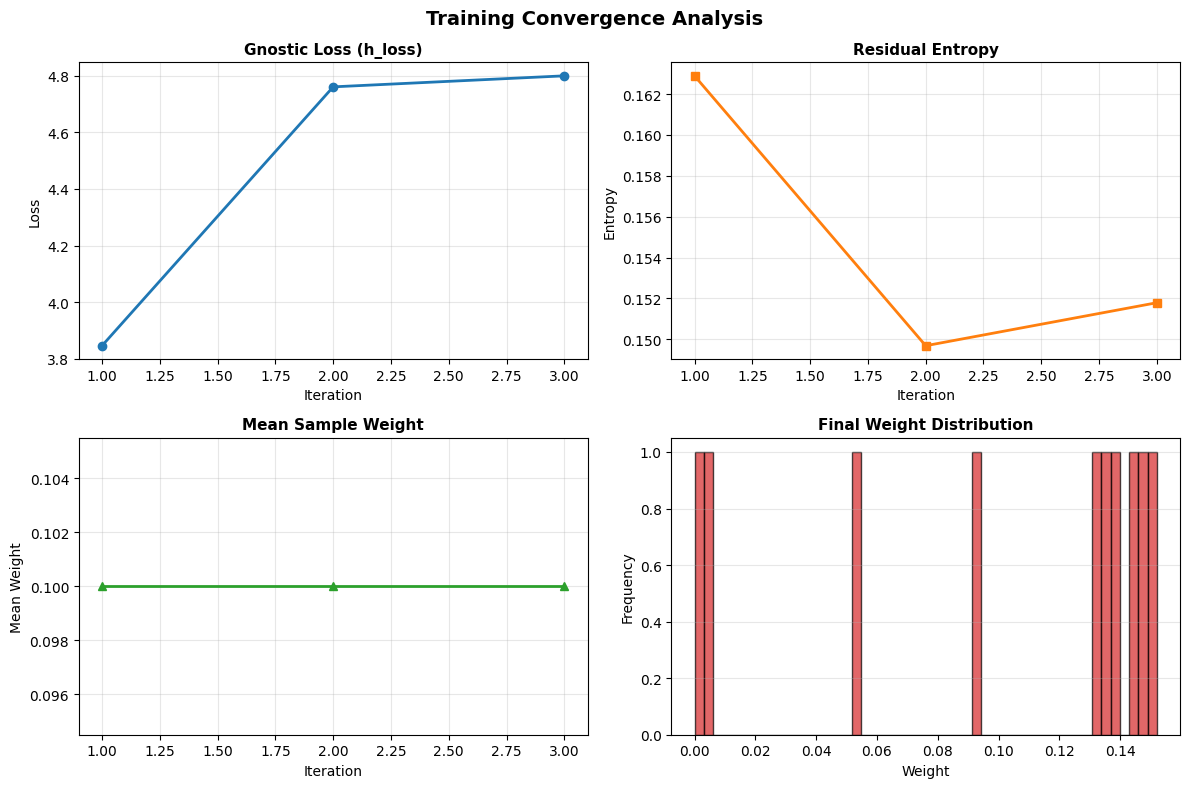


Key Observations:
- Loss and entropy decrease → model is learning
- Weights stabilize → robust sample weighting achieved
- Weight distribution shows automatic outlier down-weighting


In [9]:
# Extract metrics from history
iterations = [h['iteration'] for h in history_valid]
h_loss = [h['h_loss'] for h in history_valid]
rentropy = [h['rentropy'] for h in history_valid]
mean_weights = [np.mean(h['weights']) for h in history_valid]

# Create plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Loss over iterations
axes[0, 0].plot(iterations, h_loss, marker='o', color='tab:blue', linewidth=2)
axes[0, 0].set_title('Gnostic Loss (h_loss)', fontsize=11, fontweight='bold')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True, alpha=0.3)

# Entropy over iterations
axes[0, 1].plot(iterations, rentropy, marker='s', color='tab:orange', linewidth=2)
axes[0, 1].set_title('Residual Entropy', fontsize=11, fontweight='bold')
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('Entropy')
axes[0, 1].grid(True, alpha=0.3)

# Mean weights over iterations
axes[1, 0].plot(iterations, mean_weights, marker='^', color='tab:green', linewidth=2)
axes[1, 0].set_title('Mean Sample Weight', fontsize=11, fontweight='bold')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('Mean Weight')
axes[1, 0].grid(True, alpha=0.3)

# Weight distribution (final iteration)
final_weights = history_valid[-1]['weights']
axes[1, 1].hist(final_weights, bins=50, color='tab:red', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Final Weight Distribution', fontsize=11, fontweight='bold')
axes[1, 1].set_xlabel('Weight')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.suptitle('Training Convergence Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("- Loss and entropy decrease → model is learning")
print("- Weights stabilize → robust sample weighting achieved")
print("- Weight distribution shows automatic outlier down-weighting")